In [41]:
import pandas as pd
import numpy as np
import json

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

from sklearn.decomposition import TruncatedSVD

from keras.models import Sequential
from keras.layers import Dropout
from keras.layers import  Dense, Embedding, Bidirectional, GRU

import tensorflow as tf

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import statistics
import csv

np.random.seed(500)

In [3]:
NUMBER_OF_RECORDS = 50000

ndc_codes = pd.read_csv('../../data/processed/ndc_codes_extracted.csv', dtype=object)['NDC'].to_list()
df = pd.read_csv(
    '../../data/processed/NOTEEVENTS_ML_DATASET.csv', dtype=object, nrows=NUMBER_OF_RECORDS)

In [4]:
drug_orders =  list(map(lambda x: " ".join(eval(x)), df['TEXT_NORMALIZED_ARRAY'].to_list()))[:NUMBER_OF_RECORDS]

multi_class_labels = list(map(lambda x: json.loads(x), df['LABELS'].to_list()))[
    :NUMBER_OF_RECORDS]

y = list(map(lambda x: x[1], multi_class_labels))

NUMBER_OF_CLASSES = len(multi_class_labels[0])


In [5]:
# Vectorize drug_orders
vectorizer = TfidfVectorizer(analyzer='word')
drug_order_vectors = vectorizer.fit_transform(drug_orders)

print("TFIDF Shape", drug_order_vectors.shape)

TFIDF Shape (50000, 1520311)


In [6]:
NUMBER_OF_FEATURES = 20

pca = TruncatedSVD(n_components=NUMBER_OF_FEATURES)
result = pca.fit_transform(drug_order_vectors)

print("TSVD Shape", result.shape)

TSVD Shape (50000, 20)


In [13]:
x_train, x_test, y_train, y_test = train_test_split(
        result, y, test_size=0.2, random_state=100)
y_test = np.array(y_test)
y_train = np.array(y_train)

In [14]:
hidden_state_dimensions = [32, 64, 128]
n_unique_words = 200

history_array = []

def train_model(hidden_state, batch_size=32, epoch=3):
    model = Sequential()
    model.add(Embedding(n_unique_words, 128, input_length=NUMBER_OF_FEATURES))
    model.add(Bidirectional(GRU(hidden_state)))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation=tf.nn.tanh))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    history=model.fit(x_train, y_train,
           batch_size=32,
           epochs=3,
           validation_data=[x_test, y_test])
    print(history.history['loss'])
    print(history.history['accuracy'])

    return history

In [15]:
for hidden_state in hidden_state_dimensions:
    history_array.append(train_model(hidden_state=hidden_state))

Epoch 1/3
1250/1250 [==============================] - 11s 7ms/step - loss: 0.5702 - accuracy: 0.7542 - val_loss: 0.5551 - val_accuracy: 0.7569
Epoch 2/3
1250/1250 [==============================] - 8s 6ms/step - loss: 0.5620 - accuracy: 0.7545 - val_loss: 0.5547 - val_accuracy: 0.7569
Epoch 3/3
1250/1250 [==============================] - 8s 6ms/step - loss: 0.5610 - accuracy: 0.7545 - val_loss: 0.5548 - val_accuracy: 0.7569
[0.5701519250869751, 0.5619621872901917, 0.5609740018844604]
[0.7542499899864197, 0.7545250058174133, 0.7545250058174133]
Epoch 1/3
1250/1250 [==============================] - 18s 13ms/step - loss: 0.5655 - accuracy: 0.7543 - val_loss: 0.5552 - val_accuracy: 0.7569
Epoch 2/3
1250/1250 [==============================] - 13s 10ms/step - loss: 0.5611 - accuracy: 0.7545 - val_loss: 0.5550 - val_accuracy: 0.7569
Epoch 3/3
1250/1250 [==============================] - 12s 10ms/step - loss: 0.5601 - accuracy: 0.7545 - val_loss: 0.5552 - val_accuracy: 0.7569
[0.5655143260

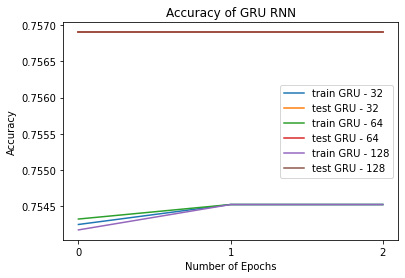

In [49]:
plt.title('Accuracy of GRU RNN')
plt.xlabel("Number of Epochs")
plt.ylabel("Accuracy")

plt.xticks([0, 1, 2])

for i in range(len(history_array)):
    history = history_array[i]

    plt.plot(history.history['accuracy'], label='train GRU - ' + str(hidden_state_dimensions[i]))
    plt.plot(history.history['val_accuracy'], label='test GRU - ' + str(hidden_state_dimensions[i]))
    
plt.legend()
plt.show();


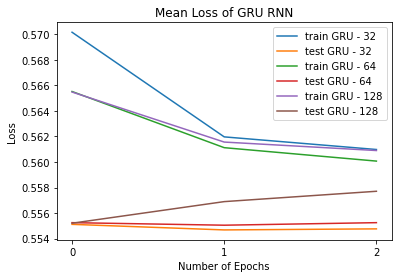

In [48]:
plt.title('Loss of GRU RNN')
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")

plt.xticks([0, 1, 2])

for i in range(len(history_array)):
    history = history_array[i]

    plt.plot(history.history['loss'], label='train GRU - ' + str(hidden_state_dimensions[i]))
    plt.plot(history.history['val_loss'], label='test GRU - ' + str(hidden_state_dimensions[i]))

plt.legend()
plt.show();

In [34]:
history_data_array = []
for i in range(len(history_array)):
    history = history_array[i]

    history_data = {'Model': 'Bidirectional GRU', 'Hidden State Size': hidden_state_dimensions[
        i], 'Number of Epochs': 3}

    history_data['Mean Training Accuracy (%)'] =  round(statistics.mean(history.history['accuracy']) * 100, 2)
    history_data['Mean Test Accuracy (%)'] = round(statistics.mean(history.history['val_accuracy']) * 100, 2)
    history_data['Mean Training Loss (%)'] = round(statistics.mean(history.history['loss']) * 100, 2)
    history_data['Mean Test Loss (%)'] = round(statistics.mean(history.history['val_loss']) * 100, 2)

    history_data_array.append(history_data)
             


In [38]:
df_results = pd.DataFrame(history_data_array)
df_results.to_csv('../../data/results/GRU_RESULTS.csv', encoding='utf-8', quotechar='"', quoting=csv.QUOTE_ALL, index=False)